# Single-phase flow

In this tutorial we investigate how to solve single-phase flow in PorePy. <br>
We consider three discretizations:
* two-point flux approximation
* multi-point flux approximation
* dual virtual element method

**Note**: This tutorial will focus on a 2d domain, however most of the code works for 1d, 2d, and 3d domains.<br>

Let $\Omega$ be a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written in
* dual formulation as:
$$\nabla \cdot \mathbf{u} = f \qquad \mathbf{u} = - K \nabla p$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad \mathbf{u} \cdot \mathbf{n} = u_b$$<br>
* primal formulation as:
$$ - \nabla \cdot K \nabla p = f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$

Here, $f$ is a scalar source/sink term, $K$ is the permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet condition), and $u_p$ is the flux at the boundary (Neumann condition).<br>

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem. <br>

For the example we assume: $\Omega = [0, 1]^2$, $\partial \Omega_d = \partial \Omega$ and $\partial \Omega_n = \emptyset$. The  data are: $f = 1$, $K = I$, and $p_b = 0$.

## Import basic modules

Before creating the grid we import NumPy, the SciPy sparse library and PorePy.

In [20]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

## Creation of the grid

We create first a Cartesian grid and compute its geometrical quantities.

In [21]:
Nx = Ny = 20                                          
g = pp.CartGrid([Nx, Ny], [2, 2])

Optionally, we manipulate the grid and then compute its geometrical quantities.

In [22]:
manipulate = False
def dist(n): return np.dot(pp.cg.rot(np.linalg.norm(n), [0, 0, 1]), n)

if manipulate:
    g.nodes[0, :] = g.nodes[0, :] - 1
    g.nodes[1, :] = g.nodes[1, :] - 1
    g.nodes = np.apply_along_axis(dist, 0, g.nodes)
    g.compute_geometry()

We plot the grid using the interface with matplotlib.

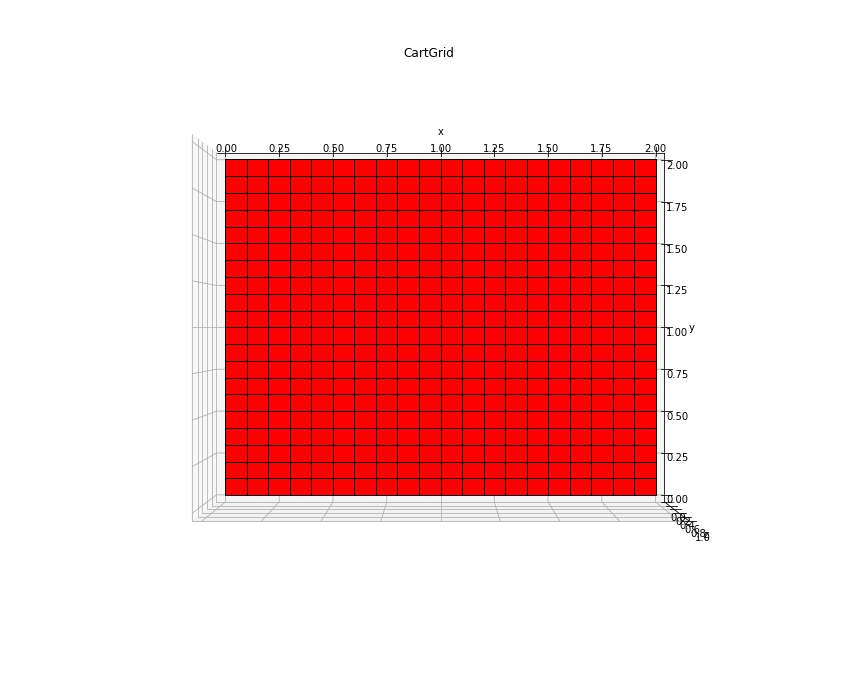

In [23]:
pp.plot_grid(g, figsize=(15, 12))

# Define the problem data

We declare the permeability matrix $K$, the scalar source term $f$, and the boundary conditions.

In [7]:
# Permeability
perm = pp.SecondOrderTensor(g.dim, np.ones(g.num_cells))                     

# Unitary scalar source already integrated in each cell
f = g.cell_volumes

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
bc = pp.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
bc_val = np.zeros(g.num_faces)

Once all the data are created we group them in a dictionary, where the keyword `"flow"` represents the physical process considered.

In [8]:
param = pp.Parameters(g)
param.set_tensor("flow", perm)
param.set_bc("flow", bc)
param.set_bc_val("flow", bc_val)
param.set_source("flow", f)
data = {'param': param}

## Problem discretization and solution

In this section we apply the different discretizations and solve the problem.

### Two-point flux approximation

The two-point flux approximation solves the single-phase flow problem in the primal formulation. The pressure is directly computed.

In [9]:
tpfa_discretizer = pp.Tpfa("flow")
A, b_flow = tpfa_discretizer.matrix_rhs(g, data)

fv_source_discretizer = pp.Integral("flow")
_, b_source = fv_source_discretizer.matrix_rhs(g, data)

p = sps.linalg.spsolve(A, b_flow + b_source) 

To represent the solution:

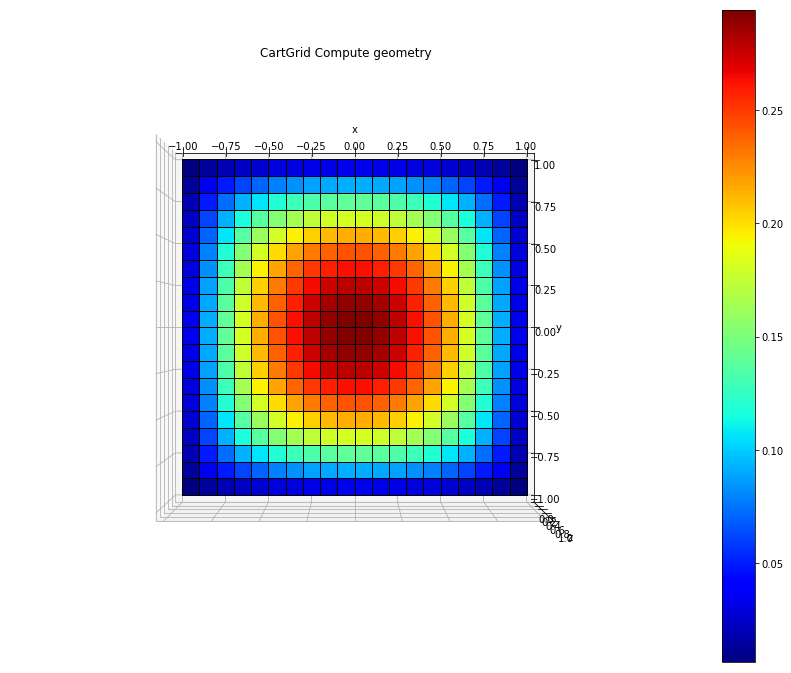

In [10]:
pp.plot_grid(g, p, figsize=(15, 12))

Consistency check:

In [12]:
assert np.isclose(np.sum(p), 56.7707373639)

### Multi-point flux approximation 

The multi-point flux approximation solves the single-phase flow problem in the primal formulation. The pressure is directly computed.

In [13]:
mpfa_discretizer = pp.Mpfa("flow")
A, b_flow = mpfa_discretizer.matrix_rhs(g, data)

p = sps.linalg.spsolve(A, b_flow+b_source)

To represent the solution:

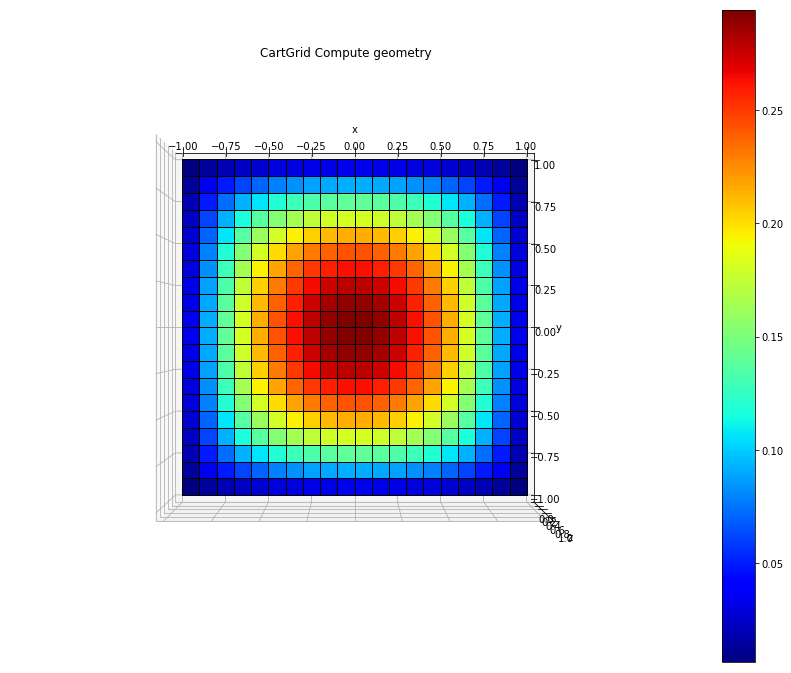

In [14]:
pp.plot_grid(g, p, figsize=(15, 12))

Consistency check:

In [16]:
assert np.isclose(np.sum(p), 56.7707373639)

### Dual virtual element method

The dual virtual element method solves the single-phase flow problem in the dual formulation. The pressure and the normal flux to each face are directly computed.

In [17]:
vem_discretizer = pp.DualVEM("flow")
A, b_flow = vem_discretizer.matrix_rhs(g, data)

vem_source_discretizer = pp.DualSource("flow")
_, b_source = vem_source_discretizer.matrix_rhs(g, data)

up = sps.linalg.spsolve(A, b_flow + b_source)                                              

# Extract the normal flux and pressure from the solution
u = vem_discretizer.extract_u(g, up)
p = vem_discretizer.extract_p(g, up) 

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = vem_discretizer.project_u(g, u, data)

We represent the solution both in terms of pressure and velocity (black arrows).

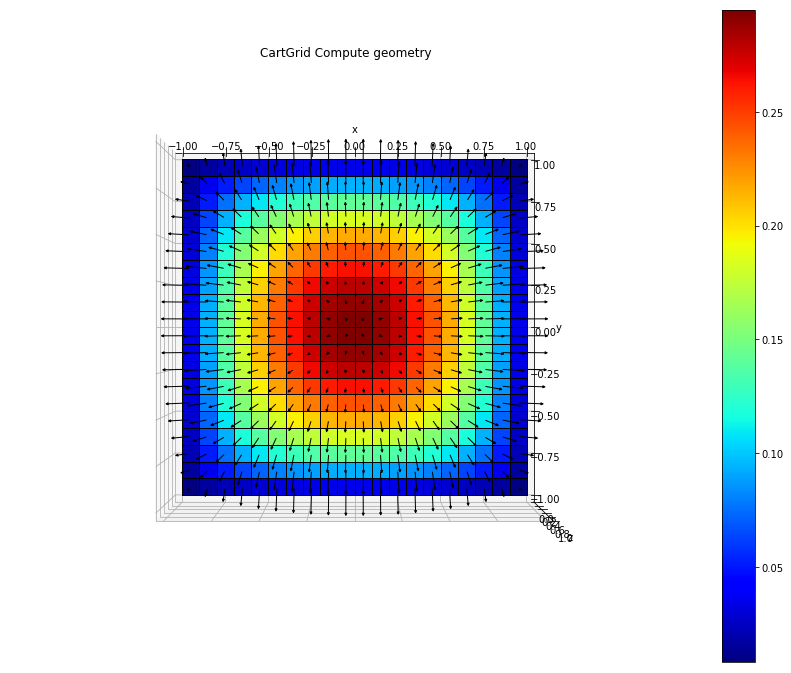

In [18]:
pp.plot_grid(g, p, P0u, figsize=(15, 12), vector_scale=.3)

Consistency check:

In [19]:
assert np.isclose(np.sum(p), 57.3922728822)
assert np.isclose(np.sum(u), 0)
assert np.isclose(np.sum(P0u), 0)

57.3922728822
